In [1]:
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
from matplotlib import cm
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib as mpl
import pickle as pkl
import os
#from kcrf.estimator import simple_estimator as np_simple_est
import time 

import torch
from torch.autograd import Variable
import torch.optim as optim
from copy import deepcopy


cwd = os.getcwd()
if  os.path.basename(os.path.normpath(cwd))=='notebooks':
    os.chdir("../")

from helpers import load_dictionary

/nfs/ghome/live/michaela/anaconda3/envs/test/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [20]:
def find_latest_file(data_dir):
    files = [file for file in os.listdir(data_dir) if file.startswith('saved_model_')]
    files.sort(key=lambda x:  int(x.split('_')[2].split('.')[0]) )
    files = [os.path.join(data_dir,file) for file in files]
    
    return files
def normalize(W):
    _,S,_ = np.linalg.svd(W)
    return W/S[0]
def generator(x,y,z, params):
    U = np.einsum('k,ij->kij',params[0][0,:], x) +np.einsum('k,ij->kij',params[0][1,:], y)+np.einsum('k,ij->kij',params[0][2,:], z)
    U += np.einsum('k,ij->kij',params[1][0,:], x**4) +np.einsum('k,ij->kij',params[1][1,:], y**4)+np.einsum('k,ij->kij',params[1][2,:], z**4)
    #R = np.linalg.norm(U, axis=0)
    R = np.sum(U**2, axis=0)
    return R*x,R*y,R*z

def energy(x,y,z,params):    
    U = np.einsum('k,ij->kij',params[0][0,:], x) +np.einsum('k,ij->kij',params[0][1,:], y)+np.einsum('k,ij->kij',params[0][2,:], z)
    U = np.maximum(U,0)- 0.1* np.maximum(-U,0)
    #U = np.einsum('lk,kij->lij',params[1], U) 
    #U = np.maximum(U,0)- 0.1* np.maximum(-U,0)
    #U = np.einsum('lk,kij->lij',params[2], U) 
    #U = np.maximum(U,0)- 0.1* np.maximum(-U,0)
    #U = np.einsum('lk,kij->lij',params[3], U)
    #U = np.maximum(U,0)- 0.1* np.maximum(-U,0)
    R = np.einsum('k,kij->ij',params[1], U) 
    return R

def make_params_from_dict(out):
    
    energy_params = [out['energy'][i].cpu().detach().numpy() for i in range(len(out['energy']))]
    base_params = [out['base'][i].cpu().detach().numpy() for i in range(len(out['base']))]
    gt_base_params = [out['true_base'][i].cpu().detach().numpy() for i in range(len(out['true_base']))]
    gt_energy_params = [out['true_energy'][i].cpu().detach().numpy() for i in range(len(out['true_energy']))]
    return energy_params, base_params ,  gt_energy_params, gt_base_params

In [43]:
Root = '/nfs/gatsbystor/michaela/projects/kale/exp/nips/train/'
log_dir = Root+'toy/samples_738468_/'
all_files = find_latest_file(log_dir)
latest_file = all_files[-1]
with open(latest_file, 'rb') as f:
    out= pkl.load(f)
energy_params, base_params, gt_energy_params, gt_base_params = make_params_from_dict(out)


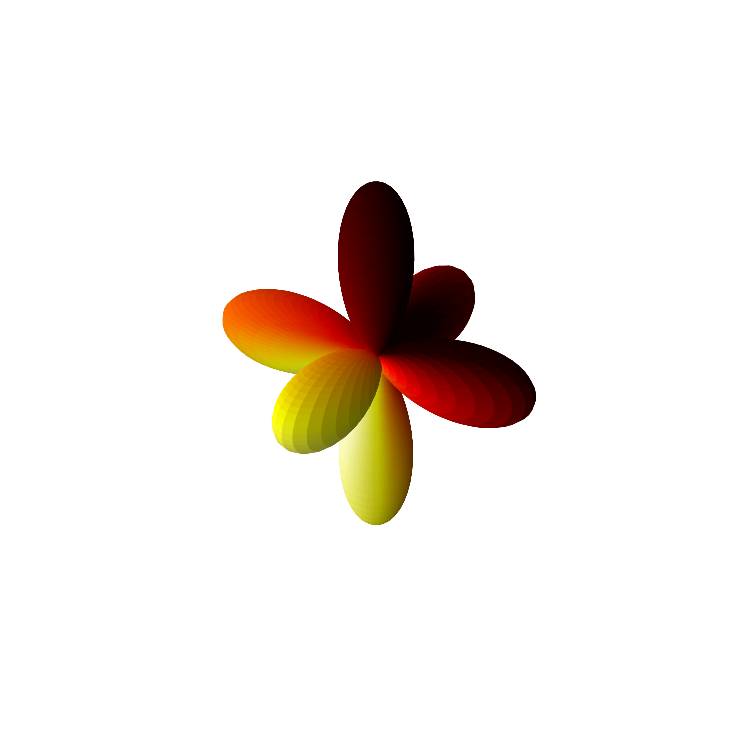

In [44]:
fig = plt.figure(figsize=(10,10))
#fig, ax = plt.subplots(1,2, figsize=(6*num_fig,5))
ax = Axes3D(fig)
#ax=fig.add_subplot(111,projection='3d')
u= np.linspace(0,2*np.pi,100)
v = np.linspace(0,np.pi,100)

# uniform on a sphere
x = 10*np.outer(np.cos(u),np.sin(v))
y = 10*np.outer(np.sin(u), np.sin(v))
z = 10*np.outer(np.ones(np.size(u)), np.cos(v))

W = np.array([[0.1,2,3],[-1,3,2],[0.3,-2,1]])


X,Y,Z = generator(x,y,z, base_params)
R = energy(x,y,z, energy_params)
colormap =( R - R.min())/(R.max()-R.min())

ax.plot_surface(X,Y,Z,rstride=1,cstride=1,facecolors=cm.hot(colormap))
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.axis('off')

plt.show()



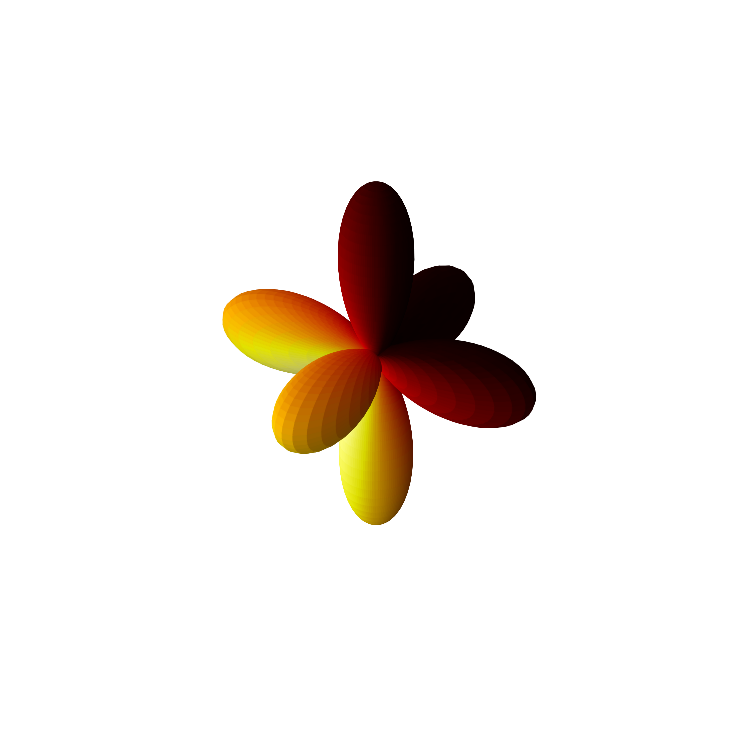

In [45]:
fig = plt.figure(figsize=(10,10))
#fig, ax = plt.subplots(1,2, figsize=(6*num_fig,5))
ax = Axes3D(fig)
#ax=fig.add_subplot(111,projection='3d')
u= np.linspace(0,2*np.pi,100)
v = np.linspace(0,np.pi,100)

# uniform on a sphere
x = 10*np.outer(np.cos(u),np.sin(v))
y = 10*np.outer(np.sin(u), np.sin(v))
z = 10*np.outer(np.ones(np.size(u)), np.cos(v))

W = np.array([[0.1,2,3],[-1,3,2],[0.3,-2,1]])


X,Y,Z = generator(x,y,z, gt_base_params)
R = energy(x,y,z, gt_energy_params)
colormap =( R - R.min())/(R.max()-R.min())



ax.plot_surface(X,Y,Z,rstride=1,cstride=1,facecolors=cm.hot(colormap))
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.axis('off')

plt.show()



In [27]:
out

{'energy': [Parameter containing:
  tensor([[-1.5039, -1.5658,  0.3479],
          [ 2.6979, -1.8348, -1.1082],
          [-1.3504,  0.0418, -1.6299]], device='cuda:0', requires_grad=True),
  Parameter containing:
  tensor([0.4648, 0.0941, 0.6817], device='cuda:0', requires_grad=True)],
 'base': [Parameter containing:
  tensor([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.]], device='cuda:0'), Parameter containing:
  tensor([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.]], device='cuda:0', requires_grad=True)],
 'true_energy': [Parameter containing:
  tensor([[ 0.0526, -0.5263, -0.5263],
          [-0.5263,  0.0526, -0.5263],
          [-0.5263, -0.5263,  0.0526]], device='cuda:0', requires_grad=True),
  Parameter containing:
  tensor([0.5774, 0.5774, 0.5774], device='cuda:0', requires_grad=True)],
 'true_base': [Parameter containing:
  tensor([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.]], device='cuda:0'), Parameter containing:
  tensor([[1